In [1]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt




C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

train = pd.read_excel('DATA.xlsx', sheet_name="training") #DATA中的资料已包含ER，读取DATA即可
test = pd.read_excel('DATA.xlsx', sheet_name="test")
train = train.drop(['SMILES'], axis=1)
test = test.drop(['SMILES'], axis=1)

train.info()#特征数据类型
train.describe()#值域
train.corr()#相关性

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Columns: 730 entries, pIC50 to Zagreb
dtypes: float64(360), int64(370)
memory usage: 11.0 MB


,pIC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
pIC50,1.000000,0.064925,0.188009,0.033048,0.425149,0.383253,0.325469,0.285981,0.361989,0.350710,...,0.318592,0.365259,0.251611,-0.074748,0.087269,-0.184031,0.089881,0.362230,0.328499,0.370748
nAcid,0.064925,1.000000,0.243518,0.091095,0.121448,0.060198,0.134609,0.116454,0.043003,0.121425,...,0.114178,0.114287,-0.112722,0.116382,0.120627,0.004035,0.014814,0.107746,0.004302,0.118274
ALogP,0.188009,0.243518,1.000000,-0.255028,-0.074840,-0.250839,0.372740,0.357599,-0.308651,-0.222162,...,-0.240888,-0.205436,0.085229,-0.415552,-0.316737,-0.424806,-0.449348,-0.167517,0.186738,-0.171981
ALogp2,0.033048,0.091095,-0.255028,1.000000,0.378497,0.429697,-0.032440,-0.034642,0.444176,0.469659,...,0.489044,0.441499,-0.140236,0.535852,0.224825,0.520573,0.935940,0.393896,-0.004351,0.408290
AMR,0.425149,0.121448,-0.074840,0.378497,1.000000,0.958476,0.517958,0.451325,0.920754,0.972396,...,0.948124,0.977560,0.234581,0.546936,0.436380,0.391155,0.544759,0.907052,0.349198,0.963613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTPT-5,-0.184031,0.004035,-0.424806,0.520573,0.391155,0.426970,0.064511,0.075692,0.434538,0.473202,...,0.493880,0.456155,-0.025577,0.751433,-0.001536,1.000000,0.597059,0.349148,-0.198666,0.420492
WPATH,0.089881,0.014814,-0.449348,0.935940,0.544759,0.609934,0.030939,0.018690,0.623473,0.642264,...,0.657014,0.618856,-0.061697,0.649472,0.361278,0.597059,1.000000,0.551611,0.010922,0.582261
WPOL,0.362230,0.107746,-0.167517,0.393896,0.907052,0.910283,0.316222,0.257757,0.890376,0.935823,...,0.905838,0.942272,0.287110,0.541695,0.495769,0.349148,0.551611,1.000000,0.282610,0.967832
XLogP,0.328499,0.004302,0.186738,-0.004351,0.349198,0.417346,0.096453,0.077495,0.427641,0.289006,...,0.259598,0.290884,0.010232,-0.293713,-0.220903,-0.198666,0.010922,0.282610,1.000000,0.268606


In [3]:
train.fillna(train.mean(), inplace=True)
train.drop_duplicates(inplace=True)

def drop_abnormal(df):
    # 通过Z-Score方法判断异常值
    df_zscore = df.copy()  # 复制一个用来存储Z-score得分的数据框
    for col in df.columns:
      df_col = df[col]  #  得到每一列的值
      z_score = (df_col - df_col.mean()) / df_col.std()  #  计算每一列的Z-score得分
      df_zscore[col] = z_score.abs() > 2.2  # 判断Z-score得分是否大于2.2，如果是则是True，否则为False

      df = df[df_zscore[col] == False]# 删除异常值所在的行
      return df


train=drop_abnormal(train)
print(train.shape)


(1941, 730)


In [4]:
# 取前20重要的特征
train2=train.drop(['pIC50'], axis=1)

x, y = train.iloc[:, 1:].values, train.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train.astype('int'))
importances = forest.feature_importances_
features = train2.columns # 读取列
features_df = pd.DataFrame({'特征':features,'重要性':importances}) #
features_df.sort_values('重要性',inplace=True,ascending=False) # 排序
features_df[:20]




,特征,重要性
39,BCUTc-1l,0.008062
238,SHsOH,0.007363
476,maxHsOH,0.006983
659,MDEC-23,0.006748
673,MLFER_A,0.006717
529,maxsOH,0.006701
22,ATSc2,0.006560
291,SsOH,0.006285
587,LipoaffinityIndex,0.006176
722,WTPT-3,0.006143


In [5]:


importances_20_name = features_df['特征'][:20].tolist()
print(importances_20_name)
important_features = [
    'BCUTc-1l', 'SHsOH', 'maxHsOH', 'MDEC-23', 'MLFER_A', 'maxsOH', 'ATSc2', 'SsOH', 'LipoaffinityIndex',
    'WTPT-3', 'BCUTc-1h', 'minsOH', 'nHBAcc', 'XLogP', 'ATSc3', 'minHsOH', 'maxssO', 'ATSc1', 'hmin', 'ATSc5'
]



['BCUTc-1l', 'SHsOH', 'maxHsOH', 'MDEC-23', 'MLFER_A', 'maxsOH', 'ATSc2', 'SsOH', 'LipoaffinityIndex', 'WTPT-3', 'BCUTc-1h', 'minsOH', 'nHBAcc', 'XLogP', 'ATSc3', 'minHsOH', 'maxssO', 'ATSc1', 'hmin', 'ATSc5']


In [6]:
# 取前20重要的特征
x = train[important_features]
test=test[important_features]
y = train['pIC50']

# 数据归一化
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_test = scaler.fit_transform(test)
y = scaler.fit_transform(y.values.reshape(-1,1))



In [7]:
# 转换数据形状以适应LSTM模型 (样本数, 时间步数, 特征数)
n_steps = 1  # 假设每个样本有1个时间步
n_features = x.shape[1]

X_train_reshaped = x.reshape((x.shape[0], n_steps, n_features))
X_test_reshaped = x_test.reshape((x_test.shape[0], n_steps, n_features))
data = {'layer1': 259, 'layer2': 410, 'layer3': 473, 'epochs': 7}
# 定义LSTM模型
model = Sequential()
model.add(LSTM(data['layer1'], activation='relu', return_sequences=True))
model.add(LSTM(data['layer2'], activation='relu', return_sequences=True))
model.add(LSTM(data['layer3'], activation='relu',return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_train_reshaped, y, epochs=data['epochs'], batch_size=20)

y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler.inverse_transform(y_pred_scaled)



Epoch 1/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - loss: 0.1124
Epoch 2/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0336
Epoch 3/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0302
Epoch 4/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0282
Epoch 5/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0266
Epoch 6/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0269
Epoch 7/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0278
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


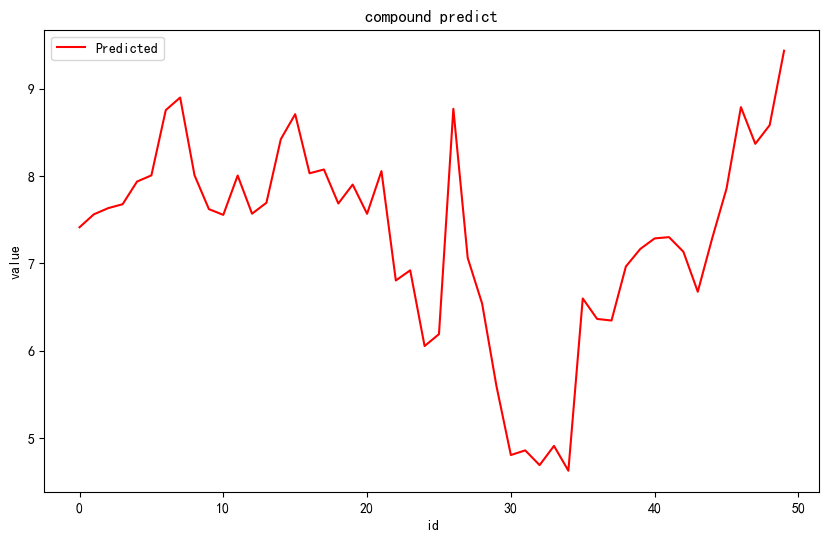

In [8]:
# 画图
plt.figure(figsize=(10, 6))

plt.plot(y_pred, color = 'red', label = 'Predicted')
plt.title('compound predict')
plt.xlabel('id')
plt.ylabel('value')

plt.legend()

plt.show()


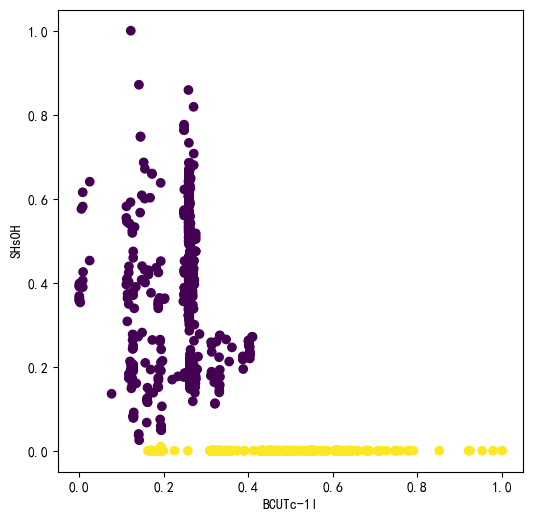

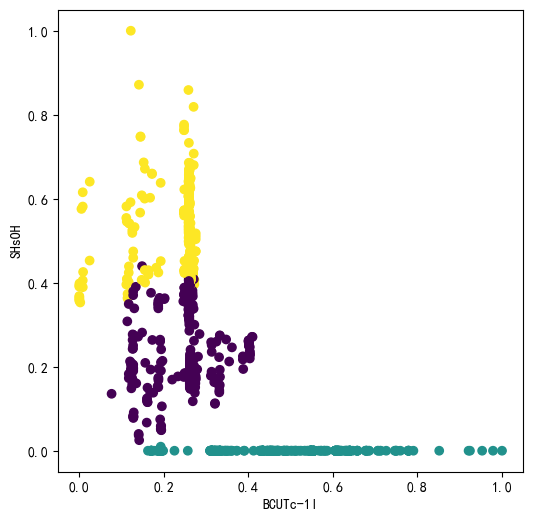

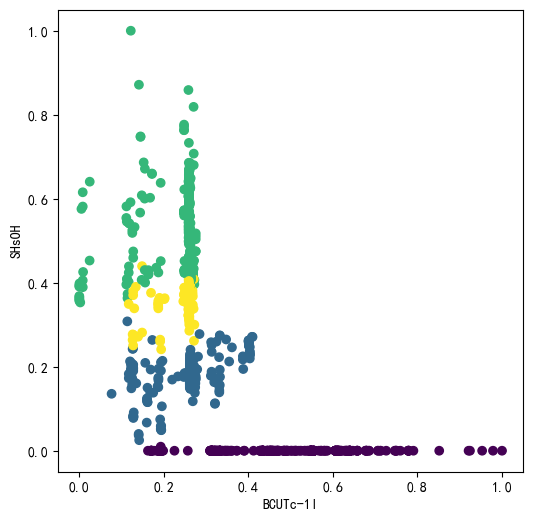

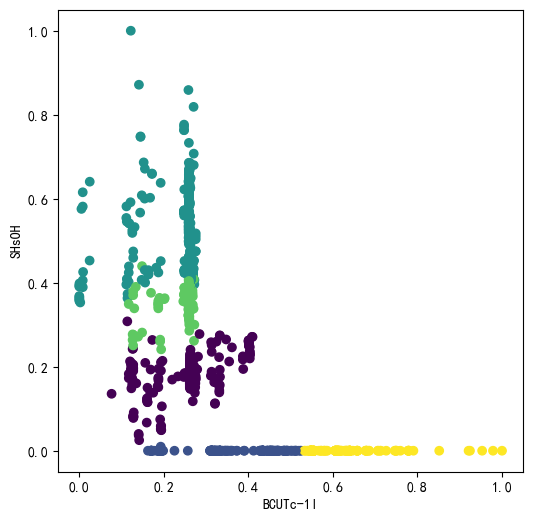

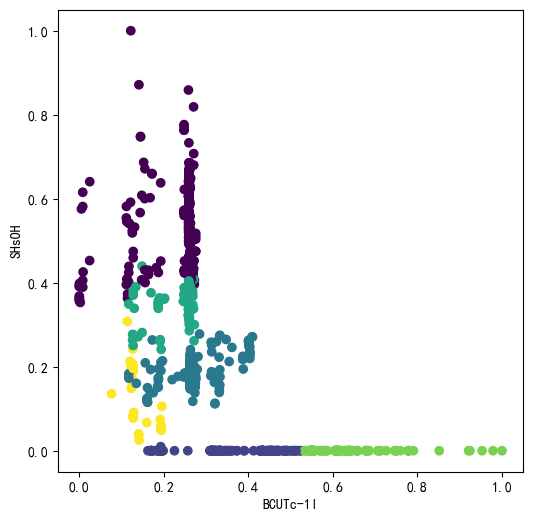

In [10]:
x=train[['BCUTc-1l', 'SHsOH', 'maxHsOH']]
x = scaler.fit_transform(x)
for n_clusters in range(2, 7):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = hierarchical.fit_predict(x)



    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=cluster_labels[:])
    plt.xlabel('BCUTc-1l')
    plt.ylabel('SHsOH')
    plt.show()




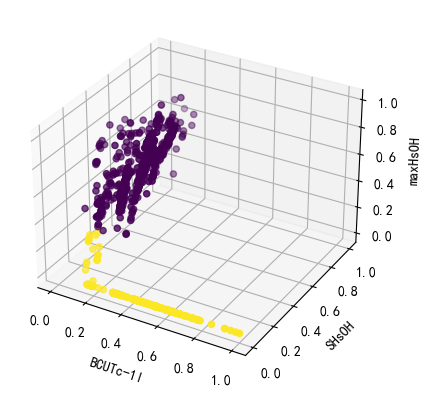

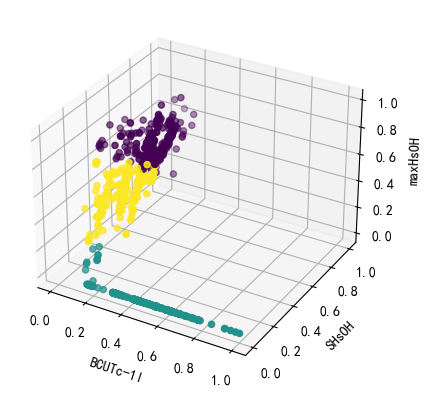

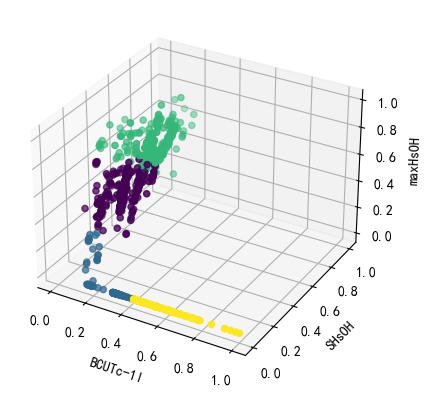

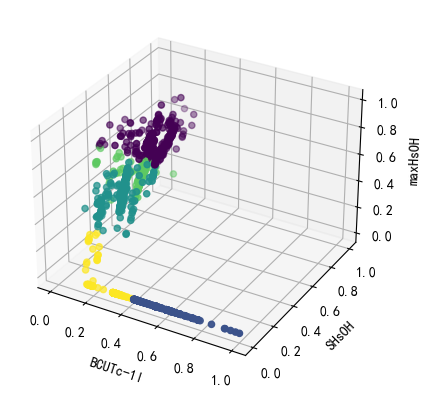

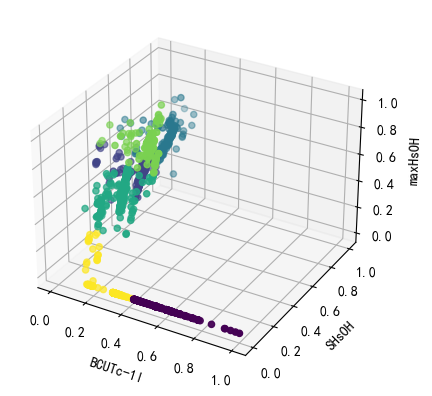

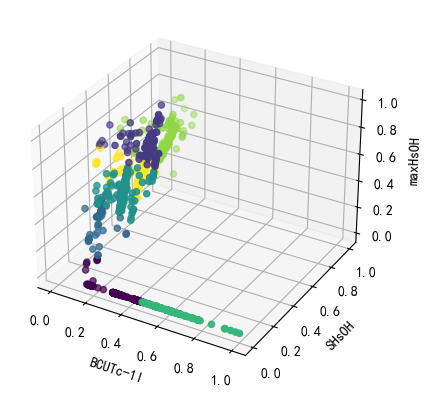

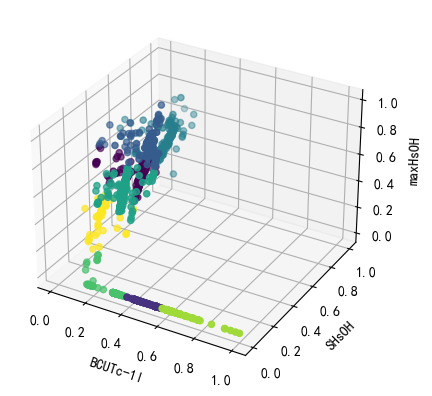

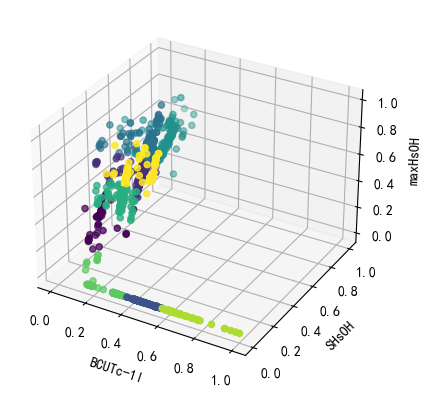

In [11]:
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    labels = kmeans.labels_





    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=labels)
    ax.set_xlabel('BCUTc-1l')
    ax.set_ylabel('SHsOH')
    ax.set_zlabel('maxHsOH')

    plt.show()



In [12]:
#结果写入excel文件


y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['PIC50']
y_pred.to_excel('OUTCOME.xlsx', index='False')
